<a href="https://colab.research.google.com/github/harshavardhan1905/UrbanFlow-simulation/blob/main/UrbanFlow-Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UrbanFlow - Dynamic Rerouting**

> Overview:-
This project is a real-time route optimization and navigation system using graph-based shortest path algorithms. The system simulates a weighted graph of locations and dynamically adjusts routes based on incidents such as roadblocks, traffic congestion, or accidents. It allows users to find the shortest path between locations, navigate manually, and handle unexpected delays by recalculating optimal routes


# # Enter Source/Origin
# # Enter Destination
# # Loads various routes and optimize them into a single route map from origin to destination
# # Calculates Estimated Time to reach
# # Start navigation
# # Once started, fetches real-time traffic data and incidents.
# # Incase any incident occured in your navigation
# # Calculate the time required to resolve the incident and compare it with the estimated time. If it exceeds the estimated time by approximately 15 minutes, take action
# # Then search for alternative routes that compensate for the 15-minute delay, ensuring we reach the destination in less time than the incident-affected route's estimated time
# #Update the estimated time and navigate through an alternative route instead of the incident-affected route

**1. Imports**

In [29]:
import networkx as nx
import matplotlib.pyplot as plt


**networkx** is used to create and manipulate graphs.

**matplotlib.pyplo**t is used to visualize the graph.



**2. Creating a Weighted Graph**

In [30]:
def create_weighted_graph():
    """Creates a weighted undirected graph with predefined edges."""
    G = nx.Graph()

    edges = [
        ('A', 'B', 4), ('A', 'C', 2), ('A', 'F', 4),
        ('B', 'C', 5), ('B', 'D', 10), ('C', 'D', 3),
        ('C', 'E', 8), ('C', 'F', 4), ('D', 'E', 7),
        ('D', 'L', 3), ('D', 'M', 6),
        ('E', 'G', 3), ('E', 'K', 3), ('F', 'G', 2),
        ('G', 'K', 3), ('K', 'L', 5), ('L', 'M', 7)
    ]

    for u, v, w in edges:
        G.add_edge(u, v, weight=w)  # Add edges with weights

    return G  # Return the graph object




This function initializes a graph and adds weighted edges between nodes.

**3. Compute Static Node** **Positions**

In [31]:
G = create_weighted_graph()
fixed_positions = nx.spring_layout(G, seed=42)  # Fixed node positions


Generates a static layout for the graph to maintain consistent positioning.

**4. Drawing the Graph**

In [32]:
def draw_graph(G, visited_nodes=set(), path=None, incident_nodes=set()):
    plt.clf()  # Clear the previous graph
    plt.figure(figsize=(8, 6))

    edge_colors = ['blue' if path and ((u, v) in path or (v, u) in path) else 'gray' for u, v in G.edges()]
    node_colors = ['white' if node in visited_nodes else ('red' if node in incident_nodes else 'lightblue') for node in G.nodes()]
    node_edge_colors = ['black' if node not in incident_nodes else 'red' for node in G.nodes()]  # Node border color

    nx.draw(G, fixed_positions, with_labels=True,
            node_color=node_colors, edge_color=edge_colors,
            node_size=3000, font_size=12, edgecolors=node_edge_colors, linewidths=2)

    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, fixed_positions, edge_labels=labels)

    plt.title("Static Weighted Graph with Shortest Path (Blue) & Incidents (Red)")
    plt.pause(0.1)  # Allows the graph to update while keeping execution running


This function visualizes the graph dynamically, updating the colors based on visited nodes and incidents.

**5. Calculating Estimated Time**

In [33]:
def calculate_estimated_time(G, path, visited_nodes):
    total_weight = sum(G[u][v]['weight'] for u, v in zip(path, path[1:]))  # Total path weight
    visited_weight = sum(G[u][v]['weight'] for u, v in zip(path, path[1:]) if u in visited_nodes and v in visited_nodes)
    return total_weight - visited_weight  # Remaining travel time


Computes the estimated time by summing the weights of edges in the path.

**6. Handling Incidents and Recalculating Paths**

In [34]:
def handle_incident(G, path, current_node, incident_nodes):
    incident_edge = input("Enter the edge where the incident occurred (format: 'A B'): ").split()
    if len(incident_edge) == 2 and incident_edge[0] in G and incident_edge[1] in G:
        extra_time = int(input("Enter additional weight (delay time) for this edge: "))
        G[incident_edge[0]][incident_edge[1]]['weight'] += extra_time  # Increase weight (delay)
        incident_nodes.update(incident_edge)  # Mark nodes as incident

        # Recalculate the shortest path from the current location
        new_path = recalculate_path(G, current_node, path[-1])
        if new_path:
            print(f"New re-routed path found: {new_path}")
            return new_path, incident_nodes
    return path, incident_nodes


If an incident occurs, the edge weight increases, and an alternative route is calculated.

**7. Manual Navigation**

In [35]:
def manual_navigation(G, path):
    visited_nodes = set()
    incident_nodes = set()
    current_index = 0  # Track user's position

    while current_index < len(path):
        draw_graph(G, visited_nodes, path, incident_nodes)
        remaining_time = calculate_estimated_time(G, path[current_index:], visited_nodes)
        print(f"Estimated remaining time: {remaining_time}")

        current_node = input(f"Enter the next node ({path[current_index]} expected): ")

        if current_node == 'exit':
            print("Navigation ended.")
            break

        if current_node == path[current_index]:
            visited_nodes.add(current_node)
            current_index += 1

            if current_index == len(path):
                print("You have reached your destination!")
                break

            incident = input("Any incident on the path? (yes/no): ").strip().lower()
            if incident == 'yes':
                path, incident_nodes = handle_incident(G, path, current_node, incident_nodes)
                current_index = 0  # Restart navigation with new path
        else:
            print(f"Invalid node! Please enter the correct next node: {path[current_index]}.")


Simulates manual navigation through the graph, allowing the user to input movement and incidents dynamically.



**8. Recalculate the Shortest Path**

In [36]:
def recalculate_path(G, source, destination):
    try:
        return nx.shortest_path(G, source=source, target=destination, weight='weight')
    except nx.NetworkXNoPath:
        print("No alternative path available!")
        return []


Finds an alternative shortest path when an incident occurs.

**9. Finding the Shortest Path**

In [37]:
def find_shortest_path(G):
    source = input("Enter source node: ")
    destination = input("Enter destination node: ")

    if source in G and destination in G:
        try:
            path = nx.shortest_path(G, source=source, target=destination, weight='weight')
            total_time = calculate_estimated_time(G, path, set())
            print(f"Shortest path from {source} to {destination}: {path} with estimated time {total_time}")
            input("Press Enter to start manual navigation...")
            manual_navigation(G, path)
        except nx.NetworkXNoPath:
            print(f"No path found between {source} and {destination}")
    else:
        print("Invalid nodes. Please enter existing nodes from the graph.")


Computes and displays the shortest path, then starts the navigation process.

**10. Run the Program**

<Figure size 640x480 with 0 Axes>

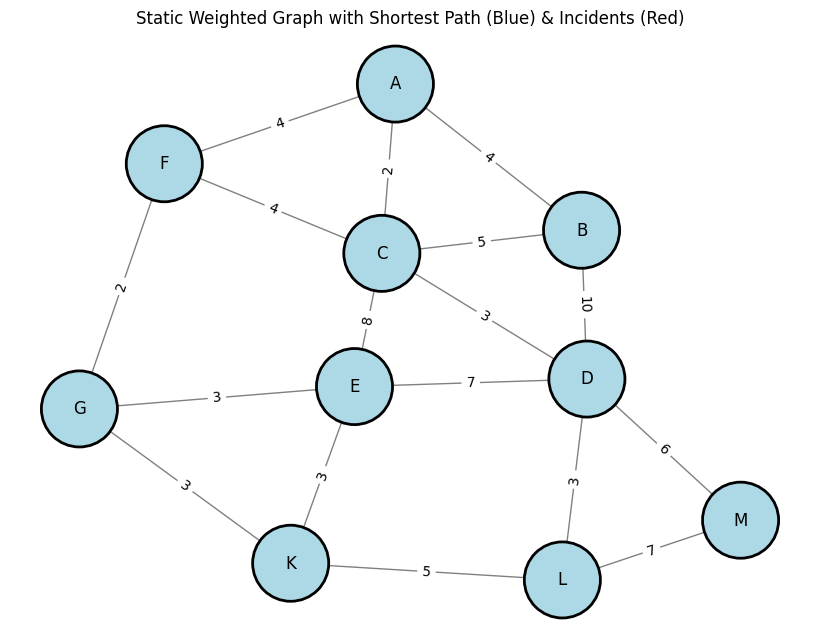

Enter source node: A
Enter destination node: K
Shortest path from A to K: ['A', 'F', 'G', 'K'] with estimated time 9
Press Enter to start manual navigation...A


<Figure size 640x480 with 0 Axes>

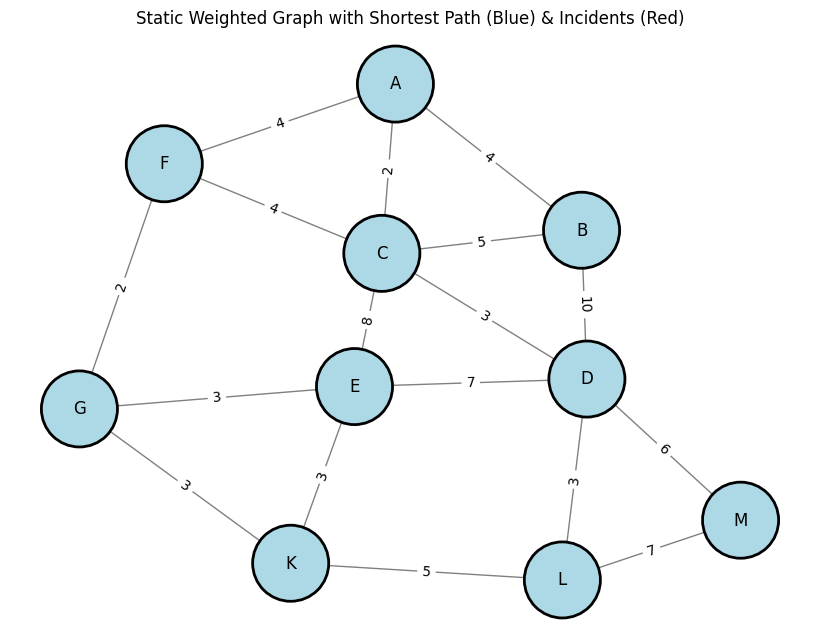

Estimated remaining time: 9
Enter the next node (A expected): A
Any incident on the path? (yes/no): no


<Figure size 640x480 with 0 Axes>

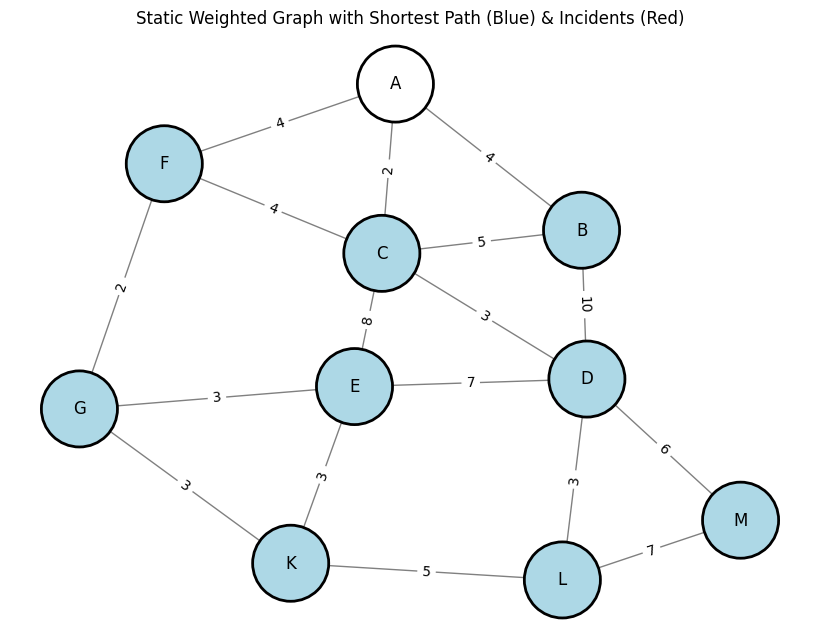

Estimated remaining time: 5
Enter the next node (F expected): F
Any incident on the path? (yes/no): no


<Figure size 640x480 with 0 Axes>

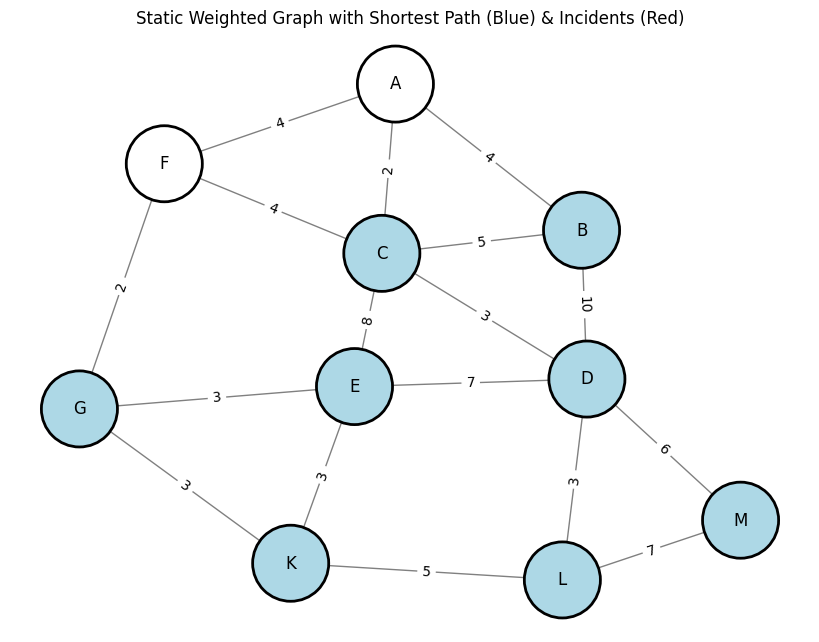

Estimated remaining time: 3
Enter the next node (G expected): G
Any incident on the path? (yes/no): yes
Enter the edge where the incident occurred (format: 'A B'): G K
Enter additional weight (delay time) for this edge: 60
New re-routed path found: ['G', 'E', 'K']


<Figure size 640x480 with 0 Axes>

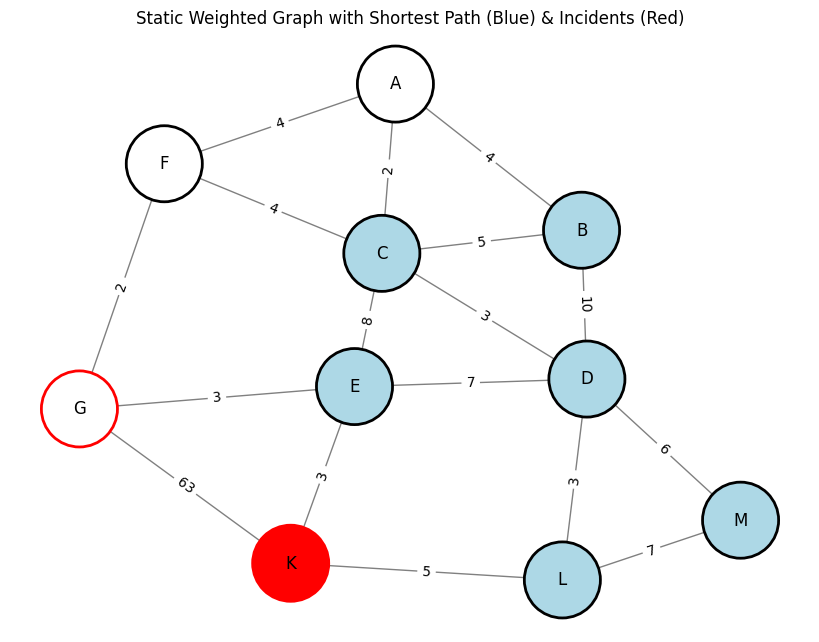

Estimated remaining time: 6
Enter the next node (G expected): G
Any incident on the path? (yes/no): no


<Figure size 640x480 with 0 Axes>

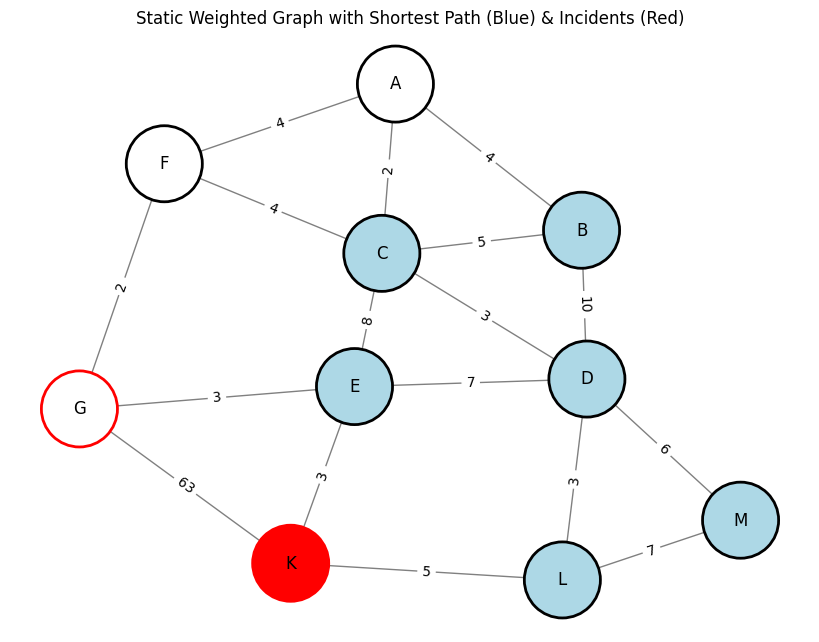

Estimated remaining time: 3
Enter the next node (E expected): E
Any incident on the path? (yes/no): no


<Figure size 640x480 with 0 Axes>

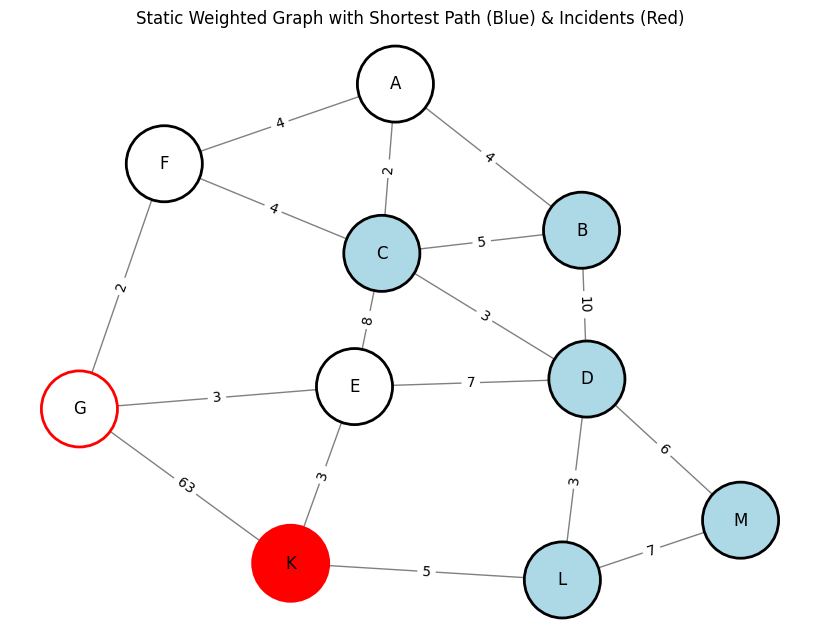

Estimated remaining time: 0
Enter the next node (K expected): K
You have reached your destination!


In [38]:
draw_graph(G)  # Draw initial static graph
find_shortest_path(G)
